In [25]:
from cryptory import Cryptory

In [26]:
my_cryptory = Cryptory(from_date="2013-04-28")

In [27]:
my_cryptory

<cryptory.cryptory.Cryptory instance at 0x7f91e63bffc8>

In [28]:
# Daily data from coinmarketcap
bitcoin_market_info = my_cryptory.extract_coinmarketcap("bitcoin")
bitcoin_market_info.loc[bitcoin_market_info['date'] == '2018-01-25' ]

,date,open,high,low,close,volume,marketcap
234,2018-01-25,11421.7,11785.7,11057.4,11259.4,8873169920,192162840576


In [29]:
# Daily subscriber numbers to the bitcoin reddit page
# my_cryptory.extract_reddit_metrics(subreddit="bitcoin", metric="total-subscribers")

In [30]:
# Google Trends - bitcoin search results
# my_cryptory.get_google_trends(kw_list=["bitcoin"])

In [31]:
# dow jones price (market code from yahoo finance)
# my_cryptory.get_stock_prices(market="%5EDJI")

In [32]:
# USD/EUR exchange rate
# my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

In [33]:
# USD/EUR exchange rate
# my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

In [34]:
# get historical commodity prices
# my_cryptory.get_metal_prices()

In [35]:
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

"""
    Func to make data from blockchain or other sources consistent with btc exchange data
    If data from APIs has data since 2009 we omit those, if no data exist of a date, the previous date value is used
"""
def drop_inititial_rows(api, start_date='2013-04-28'):
    # Read data 
    api_range_format= api+'?timespan=all&format=csv'
#     print(api_range_format)
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', 'avg_block_size'])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    elif 'transactions' in api:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', 'transactions'])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date']=df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

In [36]:
def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

In [37]:
####################################################################################################################
######## Getting Blockchain data
####################################################################################################################

# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size" 
avg_block_size = drop_inititial_rows(block_size_api)

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions" 
txs = drop_inititial_rows(txs_api)

In [198]:
####################################################################################################################
######## Getting Exchange Data, Sentiment Data (Reddit & Google Trends), Fin. Indecies (Yahoo), USD & EUR Exchanges
####################################################################################################################
my_cryptory = Cryptory(from_date="2013-04-28")

btc_market_info = my_cryptory.extract_coinmarketcap('bitcoin')
btc_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(btc_market_info['date']))
print(type(btc_market_info.volume))
pd.DataFrame(btc_market_info).fillna(btc_market_info.mean())
print((btc_market_info == np.nan).any())
# convert to int
btc_market_info['volume'] = btc_market_info['volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
btc_market_info.columns = btc_market_info.columns.str.replace("*", "")
# [['date','close','volume','open', 'high', 'how', 'Market Cap']]
btc_market_info = btc_market_info.assign(Date=pd.to_datetime(btc_market_info['date']))
rename_columns('bt_', btc_market_info)

# Calculate new columns
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'close']-x[coins+'open'])/x[coins+'open']}
    btc_market_info = btc_market_info.assign(**kwargs)

for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'high']- x[coins+'close'])/(x[coins+'high']-x[coins+'low'])-1,
            coins+'volatility': lambda x: (x[coins+'high']- x[coins+'low'])/(x[coins+'open'])}
    btc_market_info = btc_market_info.assign(**kwargs)

btc_final = btc_market_info
btc_final.to_csv('btc_data_reconciliation.csv')

# # Get volume, and rest of data

# btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
# rename_columns('google_trends_', btc_google_trends)

# Leave our reddit for now
# btc_reddit_subscribers = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
#                                          metric="total-subscribers")
# rename_columns('reddit_', btc_reddit_subscribers)

# Dow Jones price (market code)
# dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
# print(dow_jones_stock)
# Testing purposes
# dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]

# # # Exchange rates
# eur_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")

# # Left out reddit
# # btc_final = btc_market_info.merge(btc_google_trends, on='date', how='inner').merge(btc_reddit_subscribers,on='date', how='inner'). \
# #             merge(dow_jones_stock,on='date' ,how='inner'). \
# #             merge(eur_usd_exchange_rate, on='date', how='inner'). \
# #             merge(avg_block_size, on='date', how='inner')

# Get rid of columns we only needed for calculating 'close_off_high' and 'volatility'
btc_final = btc_final[['date']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['close','volume','close_off_high','volatility']]]


# need to reverse the data frame so that subsequent rows represent later timepoints
btc_final = btc_final.sort_values(by='date')
# # Alternatively, we could have scaled with scikit
from sklearn.preprocessing import minmax_scale
import numpy as np
from sklearn.preprocessing import Imputer

mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

btc_without_date = btc_final.loc[:, btc_final.columns != 'date']

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(btc_without_date)

# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(btc_without_date)

# Get back columns
imputed_df = pd.DataFrame(imputed_df, columns = btc_without_date.columns)

imputed_df[['bt_close','bt_volume','bt_close_off_high','bt_volatility']] = \
                minmax_scale(imputed_df[[ 'bt_close','bt_volume','bt_close_off_high','bt_volatility' ]])

# Re add date column
imputed_df['date'] = btc_final['date']

# Order by date
imputed_df["date"] = imputed_df["date"].values[::-1]

btc_final=imputed_df
# print(imputed_df)
# cols = imputed_df.columns.tolist()
# # Move 'date' column to first column
# cols = cols[-1:] + cols[:-1]
# # Apply change
# imputed_df = imputed_df[cols]

# # Need to scale columns (min-max scaling)
# btc_final[['google_trends_bitcoin','bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']] = (
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']]- \
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].min())/(
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].max()- \
#         btc_final[['google_trends_bitcoin', 'bt_close', 'bt_volume', 'reddit_total_subscribers', 'adjclose', 'exch_rate', 'avg_block_size']].min())

<class 'pandas.core.series.Series'>
date          True
open         False
high         False
low          False
close        False
volume       False
marketcap    False
Date          True
dtype: bool


In [203]:
# Get rid of rows where volume is 0
btc_final = btc_final[btc_final['bt_volume']!=0]
# Reindex, starting from 0 
btc_final.index = range(len(btc_final))
# btc_final.reset_index(drop=True)
print(btc_final)

      bt_close  bt_volume  bt_close_off_high  bt_volatility       date
0     0.034312   0.001966           0.664059       0.170651 2013-12-27
1     0.033939   0.001363           0.461041       0.115191 2013-12-28
2     0.034825   0.000797           0.104185       0.095655 2013-12-29
3     0.035396   0.000869           0.397193       0.072468 2013-12-30
4     0.035286   0.000877           0.293173       0.060071 2013-12-31
5     0.036182   0.000943           0.193817       0.055017 2014-01-01
6     0.037777   0.001614           0.337476       0.139924 2014-01-02
7     0.038617   0.001586           0.342660       0.114312 2014-01-03
8     0.040717   0.001594           0.000000       0.143189 2014-01-04
9     0.044526   0.003058           0.192787       0.232355 2014-01-05
10    0.045543   0.003589           0.572929       0.242576 2014-01-06
11    0.037757   0.003411           1.000000       0.352583 2014-01-07
12    0.039852   0.003111           0.295873       0.241962 2014-01-08
13    

In [208]:
split_date = '2018-04-01' # Therefore, the test dataset has values from 2018-01-03 to 2018-09-13

# we don't need the date columns anymore
training_set, test_set = btc_final[btc_final['date']<split_date], btc_final[btc_final['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)
print(test_set)

      bt_close  bt_volume  bt_close_off_high  bt_volatility
1556  0.348747   0.190098           0.405782       0.155432
1557  0.361078   0.181765           0.162031       0.094951
1558  0.380240   0.230683           0.163224       0.131558
1559  0.349242   0.207039           0.924985       0.182040
1560  0.347061   0.236540           0.423327       0.086009
1561  0.338046   0.157998           0.782930       0.084469
1562  0.352189   0.166798           0.332000       0.129109
1563  0.357975   0.153203           0.459547       0.056425
1564  0.344964   0.205280           0.789313       0.149326
1565  0.348260   0.179219           0.223761       0.050465
1566  0.355134   0.194703           0.000000       0.044890
1567  0.402534   0.373570           0.009133       0.320192
1568  0.402879   0.325678           0.677599       0.109637
1569  0.407526   0.217753           0.524142       0.076276
1570  0.425173   0.219978           0.027456       0.086394
1571  0.411254   0.236204           0.70

In [209]:
window_len = 10
norm_cols = ['bt_close','bt_volume']
print(norm_cols)

['bt_close', 'bt_volume']


In [210]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_close'][window_len:].values/training_set['bt_close'][:-window_len].values)-1

In [211]:
print(LSTM_training_outputs)

[ 0.32734309  0.11248104  0.14434986 ... -0.17109465 -0.2287101
 -0.2207181 ]


In [146]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_close'][window_len:].values/test_set['bt_close'][:-window_len].values)-1
print(LSTM_test_outputs)

[]


In [135]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [136]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    
    print(inputs.shape[1])
    print(inputs.shape[2])
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [137]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_close'][i:i+pred_range].values/
                                  training_set['bt_close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

10
4
Epoch 1/50
 - 15s - loss: 0.0787
Epoch 2/50
 - 20s - loss: 0.0619
Epoch 3/50
 - 11s - loss: 0.0593
Epoch 4/50
 - 14s - loss: 0.0590
Epoch 5/50
 - 10s - loss: 0.0579
Epoch 6/50
 - 9s - loss: 0.0573
Epoch 7/50
 - 12s - loss: 0.0567
Epoch 8/50
 - 10s - loss: 0.0561
Epoch 9/50
 - 9s - loss: 0.0568
Epoch 10/50
 - 11s - loss: 0.0559
Epoch 11/50
 - 10s - loss: 0.0558
Epoch 12/50
 - 11s - loss: 0.0560
Epoch 13/50
 - 11s - loss: 0.0560
Epoch 14/50
 - 10s - loss: 0.0559
Epoch 15/50
 - 10s - loss: 0.0559
Epoch 16/50
 - 10s - loss: 0.0557
Epoch 17/50
 - 10s - loss: 0.0562
Epoch 18/50
 - 9s - loss: 0.0563
Epoch 19/50
 - 8s - loss: 0.0558
Epoch 20/50
 - 9s - loss: 0.0561
Epoch 21/50
 - 9s - loss: 0.0558
Epoch 22/50
 - 10s - loss: 0.0557
Epoch 23/50
 - 10s - loss: 0.0560
Epoch 24/50
 - 9s - loss: 0.0555
Epoch 25/50
 - 11s - loss: 0.0556
Epoch 26/50
 - 10s - loss: 0.0560
Epoch 27/50
 - 9s - loss: 0.0550
Epoch 28/50
 - 10s - loss: 0.0552
Epoch 29/50
 - 11s - loss: 0.0553
Epoch 30/50
 - 10s - loss:

ValueError: Error when checking input: expected lstm_4_input to have 3 dimensions, but got array with shape (0, 1)

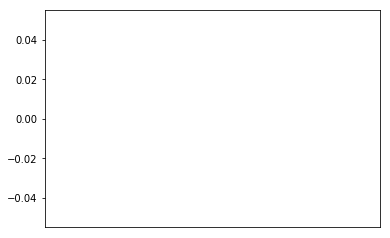

In [139]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

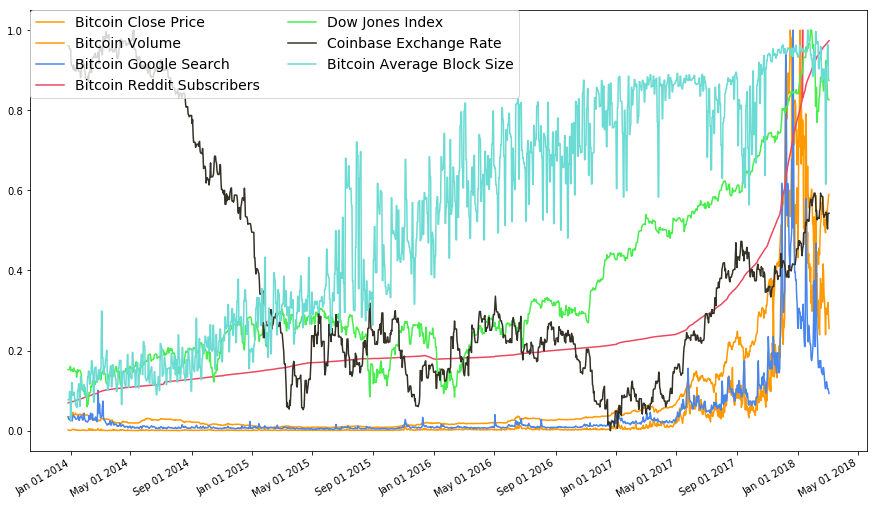

In [25]:
%matplotlib inline
fig, ax1 = plt.subplots(1, 1, figsize=(15, 9)) # 1 row 1 col

fig.autofmt_xdate()

ax1.set_xticks([datetime.date(j,i,1) for i in range(1,13,4) for j in range(2013,2019)])
ax1.set_xticklabels([datetime.date(j,i,1).strftime('%b %d %Y') 
                     for i in range(1,13,4) for j in range(2013,2019)])

ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_close'], label='Bitcoin Close Price', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['bt_volume'], label='Bitcoin Volume', color='#FF9900')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['google_trends_bitcoin'], label="Bitcoin Google Search", color='#4885ed')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['reddit_total_subscribers'], label="Bitcoin Reddit Subscribers", color='#ed475e')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['adjclose'], label="Dow Jones Index", color='#47ed4c')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['exch_rate'], label="Coinbase Exchange Rate", color='#353127')
ax1.plot(btc_final['date'].astype(datetime.datetime),
             btc_final['avg_block_size'], label="Bitcoin Average Block Size", color='#6bdbd3')

ax1.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., ncol=2, prop={'size': 14})
plt.show()

ValueError: Error when checking input: expected lstm_4_input to have 3 dimensions, but got array with shape (0, 1)

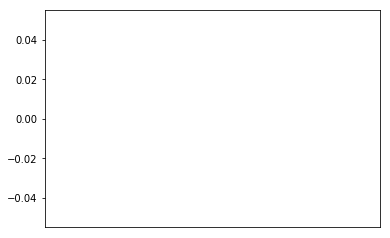

In [142]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()

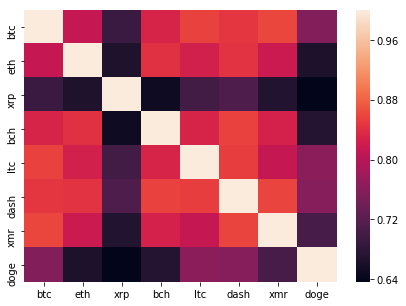

In [21]:
# Pearson correlation on all data sources
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

my_cryptory = Cryptory(from_date="2018-01-01")
all_coins_df = my_cryptory.extract_bitinfocharts("btc")
# coins of interest
bitinfocoins = ["btc", "eth", "xrp", "bch", "ltc", "dash", "xmr", "doge"]
for coin in bitinfocoins[1:]:
    all_coins_df = all_coins_df.merge(my_cryptory.extract_bitinfocharts(coin), on="date", how="left")
# date column not need for upcoming calculations
all_coins_df = all_coins_df.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_coins_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()

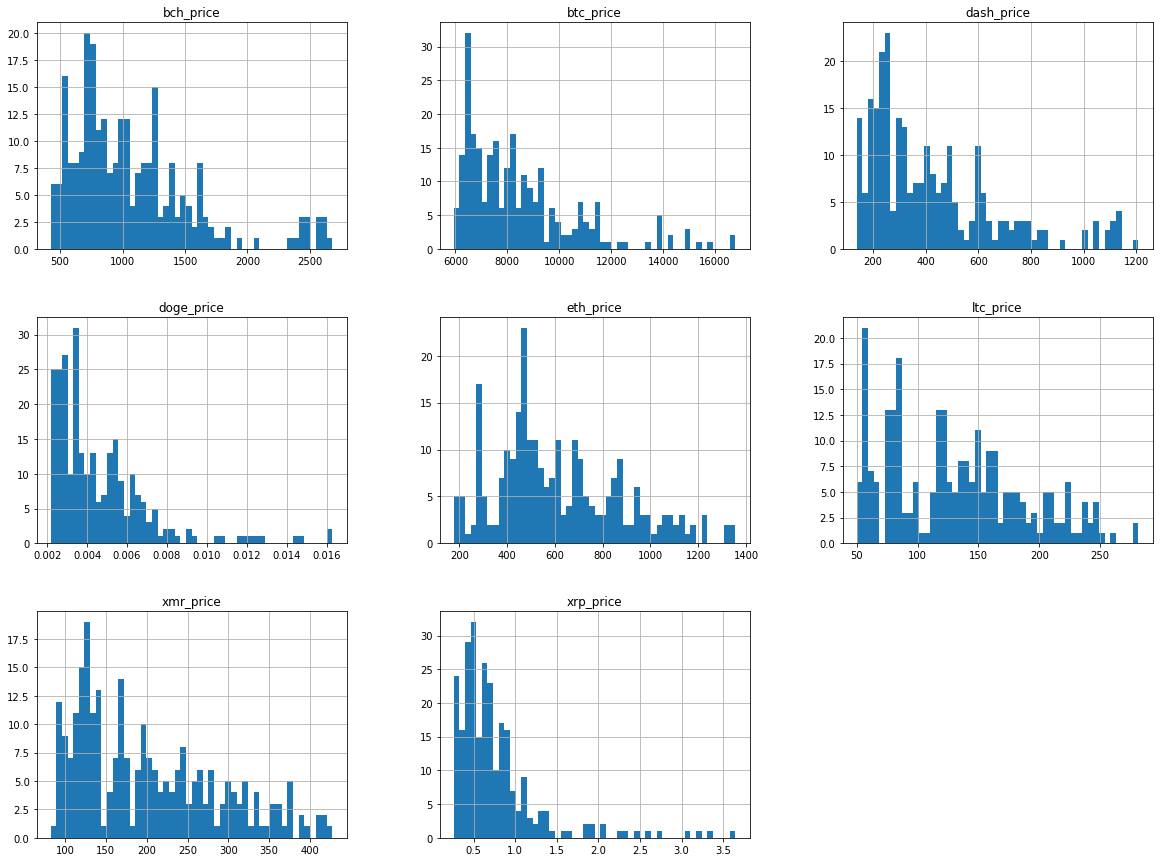

In [22]:
import matplotlib.pyplot as plt
all_coins_df.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()